In [1]:
import sys 
sys.path.append("C:/Users/L2S/Desktop/Efficient_and_reliable_GP/Code/")
sys.path.append("C:/Users/L2S/Desktop/Efficient_and_reliable_GP/Code/gaussian_process_gpmp")
from dataset_generation import sampler, extract_K_samples
from dataset_visualization import check_if_plot_is_possible, plot_1D_function, plot_2D_function_3D, plot_2D_function_heatmap
from gaussian_process import mu0_initial_guess, GaussianProcess
from gaussian_process_evaluation import GaussianProcessEvaluation
from results_visualization import ResultsVisualization
import numpy as np
import gpmp.num as gnp
import gpmp as gp
import matplotlib.pyplot as plt

Using backend: torch
Using backend: torch
Using backend: torch


# Parameters

In [2]:
# Dataset
function_name           = "Slide function"
space_size              = 5
N_function              = 500
all_function_parameters = {"Power sinus 1D"                : {"Power" : 1},
                           "Heaviside 1D"                  : {"x gaps" : [0, 0.5, 1], "steps value" : [1, -1], "sigma noises" : [0.2, 0.2]},
                           "Multimodal sinus 1D"           : {"x gaps" : [0, 0.5, 1], "speeds value" : [1, 2]},
                           "Noisy sinus 1D"                : {"sigma noise" : 0.2},
                           "Sinus times x 1D"              : {},
                           "Sinus cardinal 1D"             : {},
                           "Slide function"                : {},
                           "Two bumps"                     : {},
                           "Power sinus 2D"                : {"Power" : 1},
                           "Heaviside 2D"                  : {"x gaps" : [0, 1, 2], "steps value" : [1, -1], "sigma noises" : [0.2, 0.2]},
                           "Multimodal sinus 2D"           : {"x gaps" : [0, 1, 2], "speeds value" : [1, 2]},
                           "Noisy sinus 2D"                : {"sigma noise" : 0.2},
                           "Sinus times x 2D"              : {},
                           "Sinus cardinal 2D"             : {},
                           "Gaussian process trajectory"   : {"sigma0" : 1, "theta" : 1},
                           "Concrete compressive strength" : {},
                           "Energy efficiency"             : {},
                           "Auto mpg"                      : {},
                           "Combined cycle power plant"    : {},
                           "Airfoil self-noise"            : {},
                           "Morokoff & caflisch 1"         : {"Dimension" : 2},
                           "Morokoff & caflisch 2"         : {"Dimension" : 2},
                           "Branin"                        : {},
                           "Branin hoo"                    : {},
                           "Goldstein"                     : {},
                           "Goldstein price"               : {},
                           "Rosenbrock4"                   : {},
                           "Hartman4"                      : {},
                           "Hartman6"                      : {},
                           "Sphere6"                       : {},
                           "Iooss1"                        : {},
                           "Iooss2"                        : {},
                           "Wing weight"                   : {},
                           "Sobol"                         : {"a" : [1, 10]},
                           "Two input toy"                 : {},
                           "Highly non linear"             : {},
                           "Mystery"                       : {},
                           "Six hump camelback"            : {},
                           "Ishigami"                      : {}
                          }
N_train                 = 15
N_test                  = 5

# Dataset visualization
library                 = "plotly"
plot_type_2D            = "heatmap" # 3D or heatmap
save_path               = "C:/Users/L2S/Desktop/Efficient_and_reliable_GP/Results/"

# Gaussian process
p                       = 5
nugget                  = 1e-10
mu0                     = 1
optimization_method     = "MLE" # REML, MLE, REML - PVA, MLE - PVA, PMLE, PMLE - PVA, MSE - PVA 

# Gaussian process evaluation
n_alpha                       = 1000
range_log_sigma2              = (-5, 5)
range_log_inv_rho             = (-5, 5)
n_optimization_functions_plot = 200

# Results visualization
alpha                   = 0.95

# GPMP code
f          = gp.misc.testfunctions.twobumps
box        = [[-1], [1]] 
meanparam  = np.array([1])
covparam0  = None

def constant_mean(x, meanparam):
    return meanparam[0] * gnp.ones((x.shape[0], 1))

def kernel(x, y, covparam, pairwise=False):
    p = 5
    nugget = 1e-10
    return gp.kernel.maternp_covariance(x, y, p, covparam, pairwise, nugget)

# 1 - Dataset generation

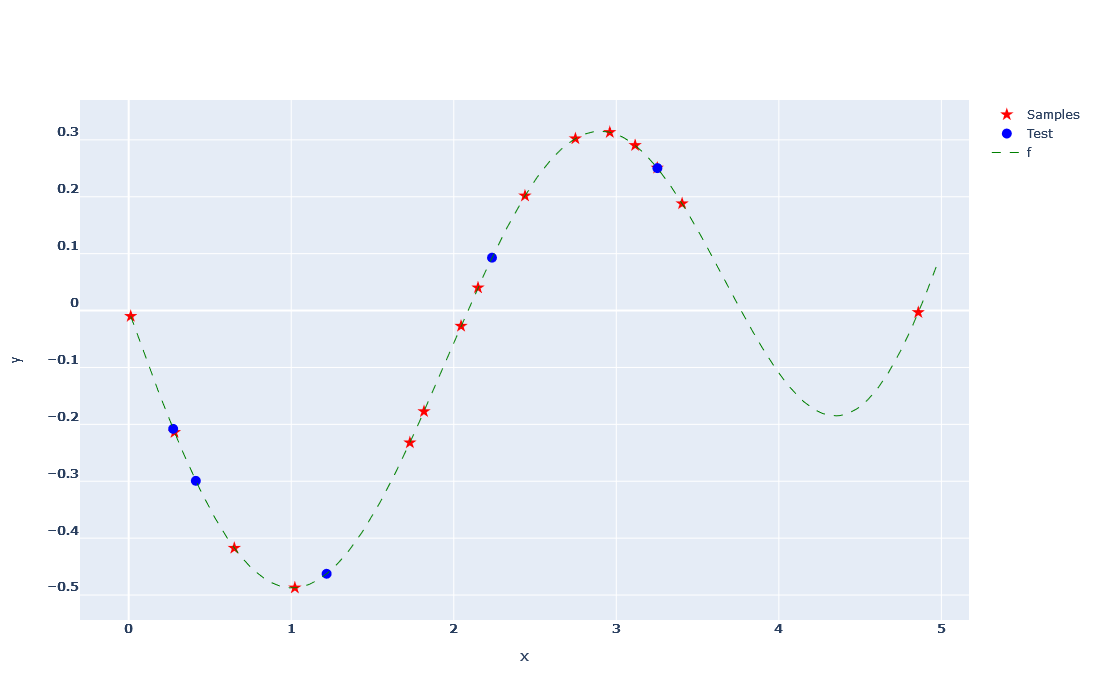

In [3]:
X_function, Y_function = sampler          (space_size, N_function, function_name, all_function_parameters)
X, Y                   = extract_K_samples(X_function, Y_function, N_train + N_test)
X_observed, Y_observed = X[:N_train], Y[:N_train ]
X_test    , Y_test     = X[N_train:], Y[ N_train:]
plot_1D_function(X_observed, Y_observed, X_test, Y_test, X_function, Y_function, library, save_path, function_name)

# 2 - Personal code

In [4]:
gaussian_process            = GaussianProcess(X_observed, Y_observed, mu0, p, optimization_method, nugget)
gaussian_process.create_and_train_gaussian_process()
#gaussian_process.set_gaussian_process_hyperparameters(0.12, [1.42])
gaussian_process_evaluation = GaussianProcessEvaluation(gaussian_process, X_observed, Y_observed, X_test, Y_test, X_function, Y_function, n_alpha, range_log_sigma2, range_log_inv_rho, n_optimization_functions_plot)
evaluation                  = gaussian_process_evaluation.evaluation()
hyperparameters             = evaluation["Hyperparameters"]
hyperparameters             = evaluation["Hyperparameters"]
library                     = library
plot_type_2D                = plot_type_2D
results_visualization       = ResultsVisualization(function_name, all_function_parameters[function_name], gaussian_process, evaluation, alpha, library, save_path)
results_visualization.create_new_folder_for_usecase()

In [5]:
my_sigma = evaluation["Optimization functions evolution"]["Negative log likelihood evolution"]["Log sigma2s"]
my_rho   = evaluation["Optimization functions evolution"]["Negative log likelihood evolution"]["Log inv rhos"]
my_l     = evaluation["Optimization functions evolution"]["Negative log likelihood evolution"]["Negative log likelihoods"]

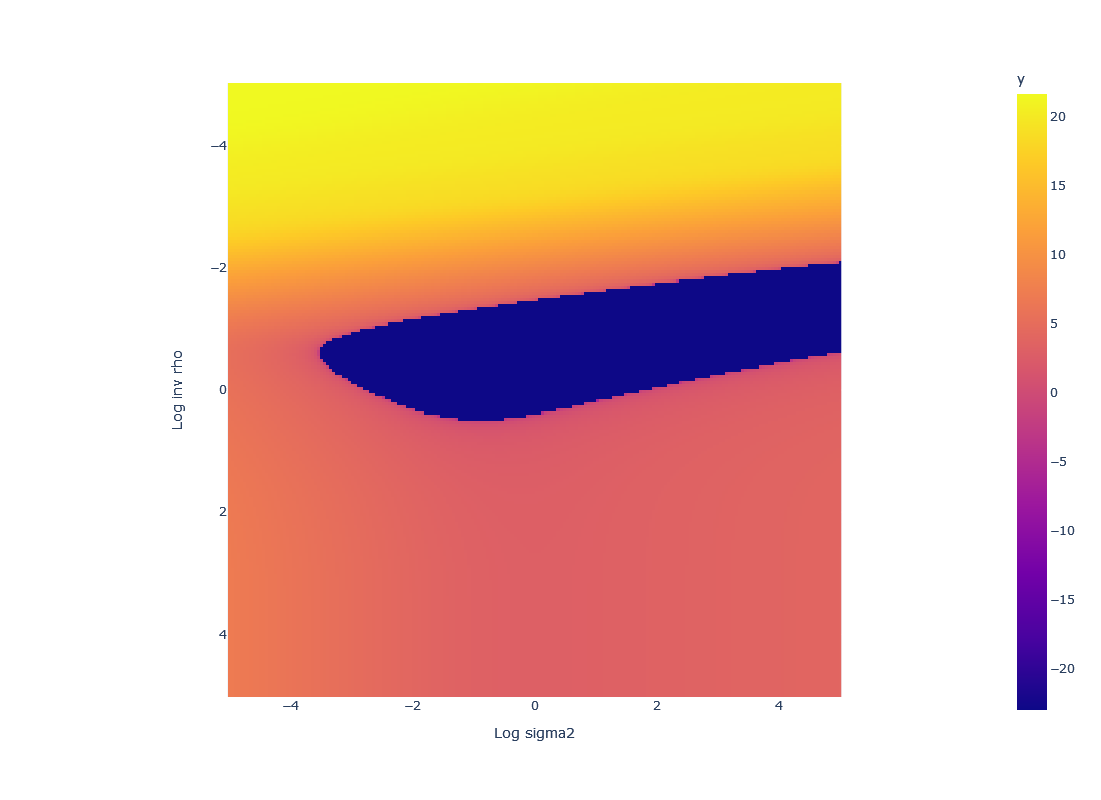

In [6]:
results_visualization.plot_negative_log_likelihood_evolution_2D_heatmap(log_scale=True)

# 3 - GPMP code

In [7]:
model               = gp.core.Model(constant_mean, kernel, meanparam, meantype="parameterized")
Y_prior_mean        = model.mean(X_observed, model.meanparam).reshape(-1)
centered_Y_observed = Y_observed - Y_prior_mean.numpy()
covparam0           = gp.kernel.anisotropic_parameters_initial_guess(model, X_observed, centered_Y_observed)
nlrl, dnlrl         = gp.kernel.make_selection_criterion_with_gradient(model.negative_log_likelihood_zero_mean, X_observed, centered_Y_observed)
covparam_reml, info = gp.kernel.autoselect_parameters(covparam0, nlrl, dnlrl, info=True)
model.covparam      = gnp.asarray(covparam_reml)
info["covparam0"]   = covparam0
info["covparam"]    = covparam_reml
Y_posterior_mean, Y_posterior_variance = model.predict(X_observed, Y_observed, X_function)
info

             message: Optimization terminated successfully
             success: True
              status: 0
                 fun: -54.218067469351055
                   x: [ 2.529e+00 -1.487e+00]
                 nit: 10
                 jac: [ 8.310e-03  5.842e-02]
                nfev: 26
                njev: 10
 best_value_returned: False
      history_params: [array([-1.065e+00, -8.849e-01]), array([ 4.978e-01, -1.912e+01]), array([-9.086e-01, -2.708e+00]), array([-1.049e+00, -1.067e+00]), array([-1.059e+00, -9.510e-01]), array([ 3.554e+00, -1.698e+00]), array([ 3.044e+00, -1.490e+00]), array([ 2.893e+00, -1.514e+00]), array([ 2.706e+00, -1.516e+00]), array([ 2.667e+00, -1.506e+00]), array([ 2.596e+00, -1.495e+00]), array([ 2.529e+00, -1.487e+00]), array([ 2.527e+00, -1.487e+00]), array([ 2.528e+00, -1.487e+00]), array([ 2.529e+00, -1.487e+00]), array([ 2.528e+00, -1.487e+00]), array([ 2.529e+00, -1.487e+00]), array([ 2.529e+00, -1.487e+00]), array([ 2.529e+00, -1.487e+00]), arr

  ***  Computing likelihood profile for plotting...
  please wait... PyTorch is slow to perform this operation...
  done.
  number of evaluations: 40000
  exec time: 44.475s


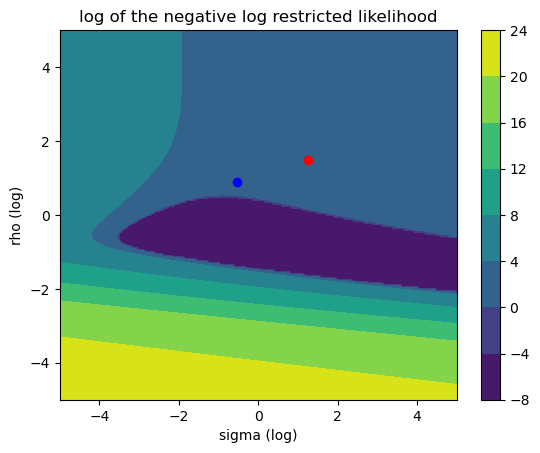

In [8]:
sigma, rho, l = gp.misc.modeldiagnosis.plot_likelihood_sigma_rho(model, info, range_log_sigma2, range_log_inv_rho, n_optimization_functions_plot)